# New Jersey County Zillow Analysis

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings('ignore')

## Business Problem

 - A real estate investment firm is interested in knowing the top three New Jersey counties to invest in based on return on investment (ROI). This notebook will analyze past ROI data in order to compare with future forecasted ROI predictions. The model used for predicting future ROI will be a SARIMA model, which takes into account the seasonal nature of the real estate market. The data will then be broken out by county and will use a stepwise fit to find optimal model orders in order to minimize AIC and produce the most accurate model based on the data. The SARIMA models will then be fitted and will forecast 5 years into the future. The models will then be analyzed taking into account RMSE as an evaluation metric. The top three counties will then be reccomended based on these methods, as well as the main counties to avoid, and the county with the lowest initial investment.     

## Load Data for Analysis

In [2]:
df = pd.read_csv('data/zillow_data.csv')

In [3]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
df.shape

(14723, 272)

## Data Description

 - The data used in this notebook will be Zillow home data ranging from April 1st, 1996 through April 1st, 2018. The data contains home value information from the United States consisting of 14,723 columns and 272 rows. For the purposes of this project the data will be filtered to only include New Jersey data. The New Jersey data will then be seperated out by individual county in order to model each county for forecasted ROI. The data will also be grouped by month for a mean value of homes for each month. The data will first need to be converted into datetime objects in order to prepare it for time series modeling. The data will also need to be converted from wide to long format in order to make it easier to work with and interperet. 

## Data Preprocessing

In [5]:
#Convert date columns to datetime objects
def get_datetimes(df):
    non_dt_cols = []
    dt_cols = []
    
    for c in df.columns:
        if c[0].isnumeric():
            dt_cols.append(c)
        else:
            non_dt_cols.append(c)
    dt_cols = list(pd.to_datetime(dt_cols, format = '%Y-%m'))
    
    df.columns = non_dt_cols + dt_cols
    return df

In [6]:
df = get_datetimes(df)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## EDA and Visualization

In [7]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

## Reshape from Wide to Long Format

In [8]:
#Function to melt dataframe with datetime columns
def melt_data(df):
    melted = pd.melt(
        df,
        id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'],
        var_name='time')
    melted = melted.dropna(subset=['value'])
    return melted

In [9]:
#Updated dataframe
melted_df = melt_data(df)
melted_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [10]:
#Melted dataframe info
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744704 entries, 0 to 3901594
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionID    int64         
 1   RegionName  int64         
 2   City        object        
 3   State       object        
 4   Metro       object        
 5   CountyName  object        
 6   SizeRank    int64         
 7   time        datetime64[ns]
 8   value       float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 285.7+ MB


## Seperate New Jersey Data

In [11]:
#Select NJ data for analysis
nj_df = melted_df[melted_df['State'] == 'NJ']
nj_df.set_index('time', inplace=True)

In [12]:
nj_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0
1996-04-01,61148,8701,Lakewood,NJ,New York,Ocean,74,153800.0
1996-04-01,61169,8753,Toms River,NJ,New York,Ocean,159,123400.0
1996-04-01,60518,7002,Bayonne,NJ,New York,Hudson,188,145000.0
1996-04-01,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0


In [13]:
nj_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133030 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   RegionID    133030 non-null  int64  
 1   RegionName  133030 non-null  int64  
 2   City        133030 non-null  object 
 3   State       133030 non-null  object 
 4   Metro       133030 non-null  object 
 5   CountyName  133030 non-null  object 
 6   SizeRank    133030 non-null  int64  
 7   value       133030 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 9.1+ MB


In [14]:
#Change columns from int64 to string
nj_df['RegionID'] = nj_df['RegionID'].astype(str)
nj_df['RegionName'] = nj_df['RegionName'].astype(str)
nj_df['SizeRank'] = nj_df['SizeRank'].astype(str)

In [15]:
def plot_values(df, title):
#Plot the average annual home values of a dataframe
    df.resample(rule='A').mean().plot(figsize=(15,5))
    plt.grid()
    plt.title(title);

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


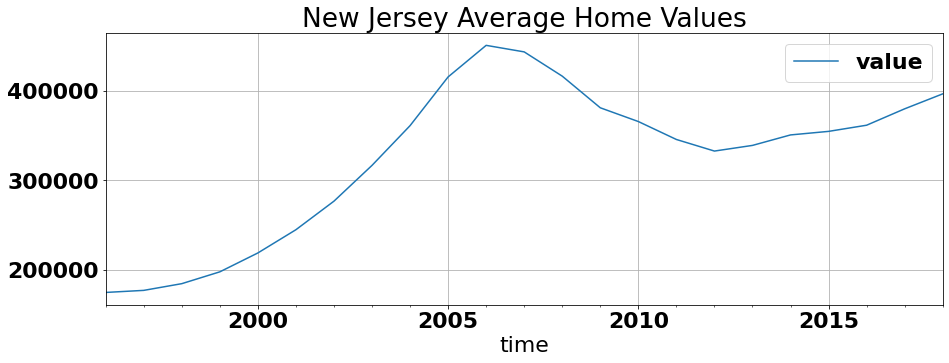

In [16]:
#Plot NJ average home values
plot_values(nj_df, 'New Jersey Average Home Values')

 - Overall New Jersey home values appear to have sharply increased from 1996 through around 2006 before significantly dropping in value from 2008 to around 2012. This is likely due to the housing crisis and recession starting in 2008. Since around 2012 home values appear to be steadily increasing across the state as the economy began to steadily improve during this time period. Overall the data does not appear to be stationary as it follows a general upward trend.

In [17]:
#Function to help interpret Dickey-Fuller test results
def adfuller_of(series):
    """Prints the Augmented Dickey-Fuller test results."""
    
    adf, pvalue, usedlag, nobs, crit_vals, resstore = adfuller(series)
    print(f'''
                          ADF: {adf}
                      P-Value: {pvalue}
                     Used Lag: {usedlag}
       Number of Observations: {nobs}
    Critical Values (for ADF): {crit_vals}
                  ResultStore: {resstore}
    ''')

In [18]:
#Perfrom Dickey-Fuller test to check for stationarity
adfuller_of(nj_df['value'])

In [19]:
#Resample NJ data by month
nj_monthly = nj_df.resample(rule='M').mean()

In [20]:
#Run a seasonal decomposition to check from trends, seasonality, and residual values
decomposition = seasonal_decompose(nj_monthly['value'])

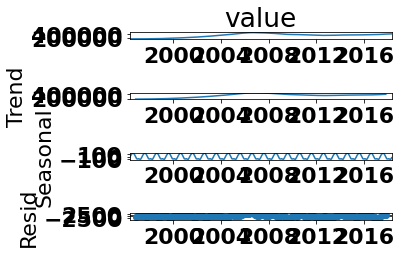

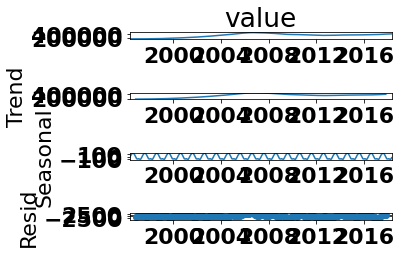

In [184]:
decomposition.plot()

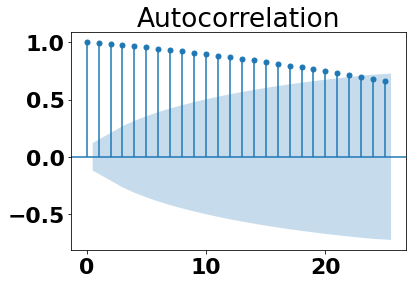

In [185]:
#Plot the autocorrelation function
plot_acf(nj_monthly['value']);

 - Graph shows the data is correlated up to about 20 lags.

In [22]:
def get_roi(df):
#Calculate return on investment from a datframe
    resampled_df = df.resample(rule='A').mean()
    cost = resampled_df.iloc[0,0]
    value = resampled_df.iloc[-1,0]
    ROI = (value-cost)/cost
    return print(f'1996-2018 Return on Investment: {round(ROI, 2)}')

In [23]:
get_roi(nj_df)

1996-2018 Return on Investment: 1.27


## Seperate Data into Individual Counties

In [24]:
#Check unique county names
melted_df[melted_df['State'] == 'NJ']['CountyName'].unique()

array(['Hudson', 'Ocean', 'Middlesex', 'Somerset', 'Monmouth', 'Passaic',
       'Essex', 'Camden', 'Bergen', 'Burlington', 'Union', 'Mercer',
       'Morris', 'Atlantic', 'Gloucester', 'Cumberland', 'Warren',
       'Hunterdon', 'Cape May', 'Sussex', 'Salem'], dtype=object)

## Data Exploration

 - Will break the data out into individual counties, plot the data, as well as calculate county ROI's for analysis.

### Hudson County Analysis

In [25]:
def county_df(county):
#Create seperate county dataframes from NJ dataframe
    county_df = nj_df[(nj_df['CountyName'] == county)]
    return county_df

In [26]:
#Create Hudson County dataframe
hudson_df = county_df('Hudson')
hudson_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0
1996-04-01,60518,7002,Bayonne,NJ,New York,Hudson,188,145000.0
1996-04-01,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0
1996-04-01,60599,7093,West New York,NJ,New York,Hudson,215,131700.0
1996-04-01,60594,7087,Union City,NJ,New York,Hudson,320,127300.0


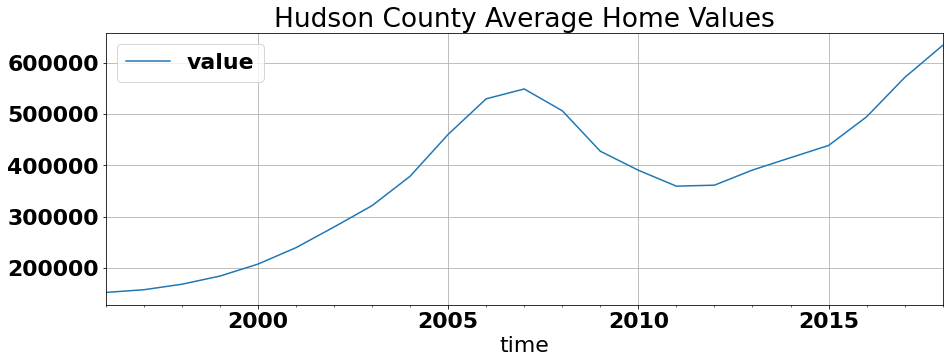

In [27]:
#Plot Hudson County Average Values
plot_values(hudson_df, 'Hudson County Average Home Values')

In [28]:
#Calculates ROI of a dataframe and appends values to a list
roi_lst = []
def county_roi(df):
    resampled_df = df.resample(rule='A').mean()
    cost = resampled_df.iloc[0,0]
    value = resampled_df.iloc[-1,0]
    ROI = (value-cost)/cost
    roi_lst.append(round(ROI,2))
    return print(f'Average County Return on Investment (1996-2018): {round(ROI,2)}')

In [29]:
county_roi(hudson_df)

Average County Return on Investment (1996-2018): 3.15


### Ocean County Analysis

In [30]:
ocean_df = county_df('Ocean')
ocean_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61148,8701,Lakewood,NJ,New York,Ocean,74,153800.0
1996-04-01,61169,8753,Toms River,NJ,New York,Ocean,159,123400.0
1996-04-01,61175,8759,Manchester,NJ,New York,Ocean,529,100900.0
1996-04-01,61093,8527,Jackson,NJ,New York,Ocean,569,151000.0
1996-04-01,61173,8757,Berkeley,NJ,New York,Ocean,1069,93200.0


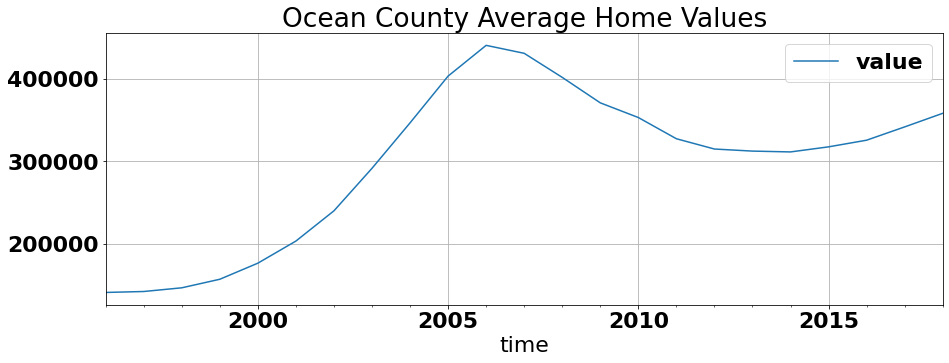

In [31]:
plot_values(ocean_df, 'Ocean County Average Home Values')

In [32]:
county_roi(ocean_df)

Average County Return on Investment (1996-2018): 1.54


### Middlesex County Analysis

In [33]:
middlesex_df = county_df('Middlesex')
middlesex_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61200,8831,Monroe,NJ,New York,Middlesex,279,218500.0
1996-04-01,61214,8854,Piscataway,NJ,New York,Middlesex,1044,161800.0
1996-04-01,61186,8816,East Brunswick,NJ,New York,Middlesex,1180,196000.0
1996-04-01,61187,8817,Edison,NJ,New York,Middlesex,1412,139200.0
1996-04-01,61219,8861,Perth Amboy,NJ,New York,Middlesex,1675,108000.0


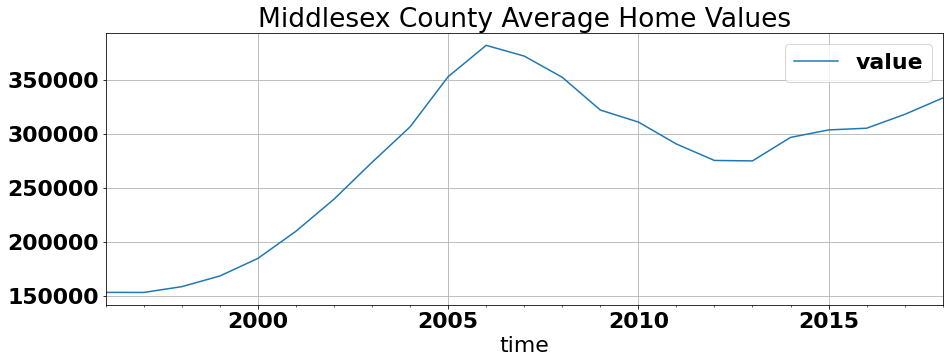

In [34]:
plot_values(middlesex_df, 'Middlesex County Average Home Values')

In [35]:
county_roi(middlesex_df)

Average County Return on Investment (1996-2018): 1.17


### Somerset County Analysis

In [36]:
somerset_df = county_df('Somerset')
somerset_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61229,8873,Franklin,NJ,New York,Somerset,550,161100.0
1996-04-01,61208,8844,Hillsborough,NJ,New York,Somerset,1942,227200.0
1996-04-01,61181,8807,Bridgewater,NJ,New York,Somerset,2230,222600.0
1996-04-01,60864,7920,Bernards,NJ,New York,Somerset,4073,354600.0
1996-04-01,61231,8876,Branchburg,NJ,New York,Somerset,4987,177200.0


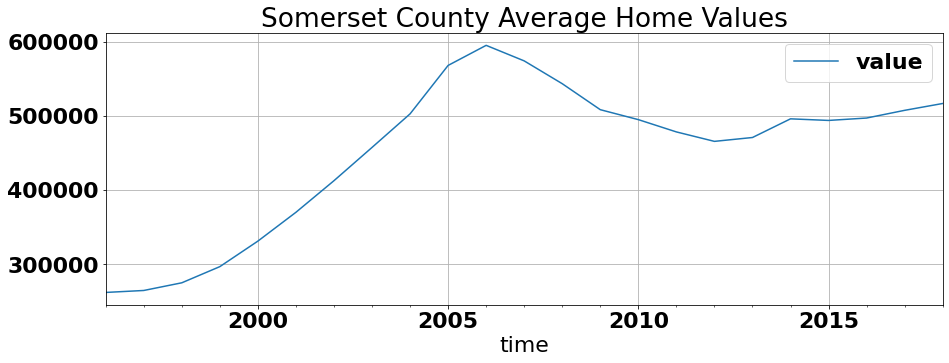

In [37]:
plot_values(somerset_df, 'Somerset County Average Home Values')

In [38]:
county_roi(somerset_df)

Average County Return on Investment (1996-2018): 0.97


### Monmouth County Analysis

In [39]:
monmouth_df = county_df('Monmouth')
monmouth_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60776,7728,Freehold,NJ,New York,Monmouth,577,200200.0
1996-04-01,60763,7712,Ocean,NJ,New York,Monmouth,1110,159300.0
1996-04-01,60774,7726,Manalapan,NJ,New York,Monmouth,1499,205700.0
1996-04-01,60793,7753,Neptune,NJ,New York,Monmouth,1704,119400.0
1996-04-01,60786,7740,Long Branch,NJ,New York,Monmouth,2483,116100.0


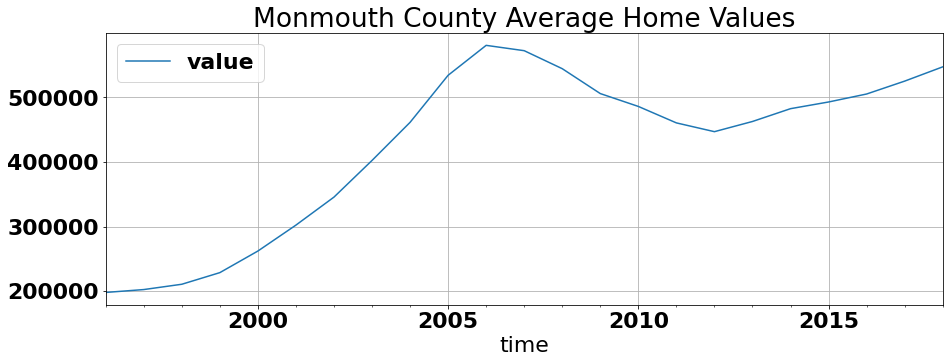

In [40]:
plot_values(monmouth_df, 'Monmouth County Average Home Values')

In [41]:
county_roi(monmouth_df)

Average County Return on Investment (1996-2018): 1.76


### Passaic County Analysis

In [42]:
passaic_df = county_df('Passaic')
passaic_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60565,7055,Passaic,NJ,New York,Passaic,623,133100.0
1996-04-01,60688,7470,Wayne,NJ,New York,Passaic,841,240400.0
1996-04-01,60527,7011,Clifton,NJ,New York,Passaic,3129,147600.0
1996-04-01,60529,7013,Clifton,NJ,New York,Passaic,3969,170800.0
1996-04-01,60694,7501,Paterson,NJ,New York,Passaic,4045,105400.0


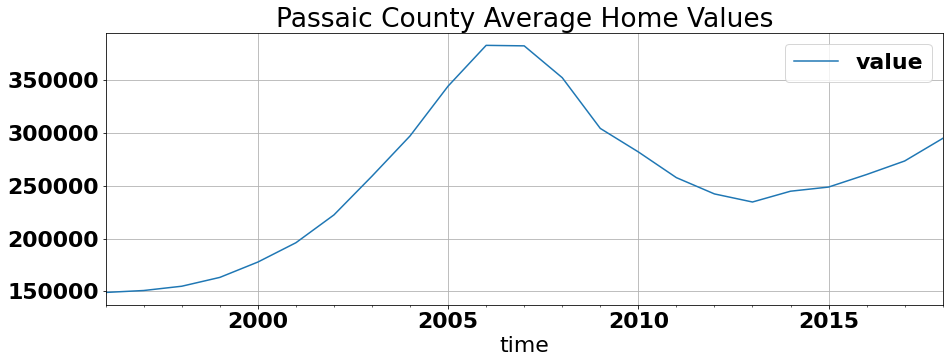

In [43]:
plot_values(passaic_df, 'Passaic County Average Home Values')

In [44]:
county_roi(passaic_df)

Average County Return on Investment (1996-2018): 0.98


### Essex County Analysis

In [45]:
essex_df = county_df('Essex')
essex_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60519,7003,Bloomfield,NJ,New York,Essex,642,140800.0
1996-04-01,60608,7104,Newark,NJ,New York,Essex,1115,114100.0
1996-04-01,60563,7052,West Orange,NJ,New York,Essex,1171,165300.0
1996-04-01,60609,7105,Newark,NJ,New York,Essex,1797,164500.0
1996-04-01,60613,7109,Belleville,NJ,New York,Essex,2698,123400.0


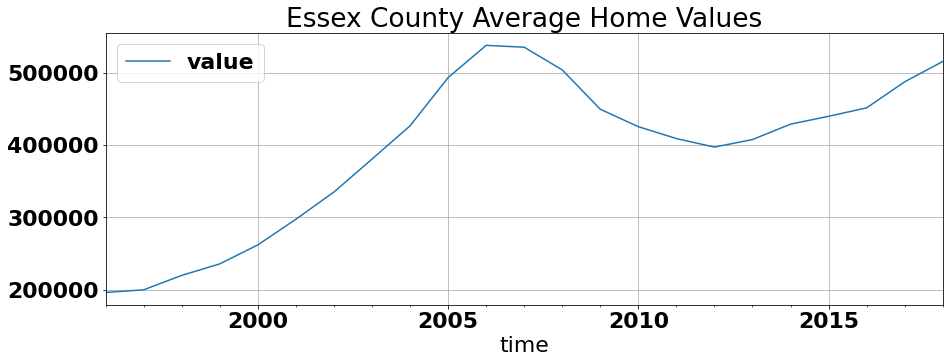

In [46]:
plot_values(essex_df, 'Essex County Average Home Values')

In [47]:
county_roi(essex_df)

Average County Return on Investment (1996-2018): 1.63


### Camden County Analysis

In [48]:
camden_df = county_df('Camden')
camden_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60916,8021,Lindenwold,NJ,Philadelphia,Camden,679,84800.0
1996-04-01,60971,8081,Winslow,NJ,Philadelphia,Camden,1099,112800.0
1996-04-01,60909,8012,Gloucester,NJ,Philadelphia,Camden,1775,115100.0
1996-04-01,60936,8043,Voorhees,NJ,Philadelphia,Camden,3046,180300.0
1996-04-01,60900,8003,Cherry Hill,NJ,Philadelphia,Camden,3552,170500.0


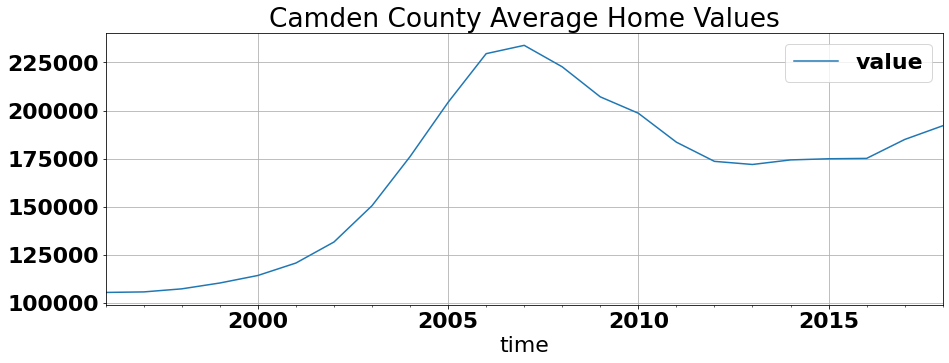

In [49]:
plot_values(camden_df, 'Camden County Average Home Values')

In [50]:
county_roi(camden_df)

Average County Return on Investment (1996-2018): 0.82


### Bergen County Analysis

In [51]:
bergen_df = county_df('Bergen')
bergen_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60714,7601,Hackensack,NJ,New York,Bergen,833,157500.0
1996-04-01,60540,7024,Fort Lee,NJ,New York,Bergen,948,260200.0
1996-04-01,60750,7666,Teaneck,NJ,New York,Bergen,2344,170800.0
1996-04-01,60656,7410,Fair Lawn,NJ,New York,Bergen,3204,180500.0
1996-04-01,60729,7631,Englewood,NJ,New York,Bergen,3954,163300.0


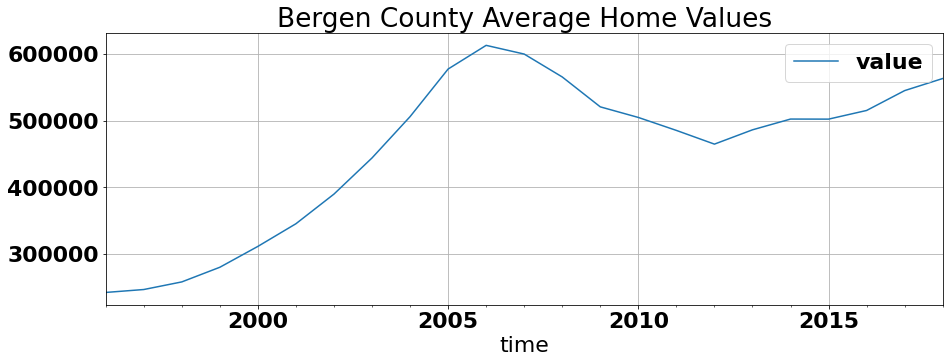

In [52]:
plot_values(bergen_df, 'Bergen County Average Home Values')

In [53]:
county_roi(bergen_df)

Average County Return on Investment (1996-2018): 1.32


### Burlington County Analysis

In [54]:
burlington_df = county_df('Burlington')
burlington_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60945,8054,Mt Laurel,NJ,Philadelphia,Burlington,851,158500.0
1996-04-01,60944,8053,Evesham,NJ,Philadelphia,Burlington,917,149400.0
1996-04-01,60912,8016,Burlington,NJ,Philadelphia,Burlington,2893,121100.0
1996-04-01,60938,8046,Willingboro,NJ,Philadelphia,Burlington,3535,89600.0
1996-04-01,60965,8075,Delran,NJ,Philadelphia,Burlington,3550,117400.0


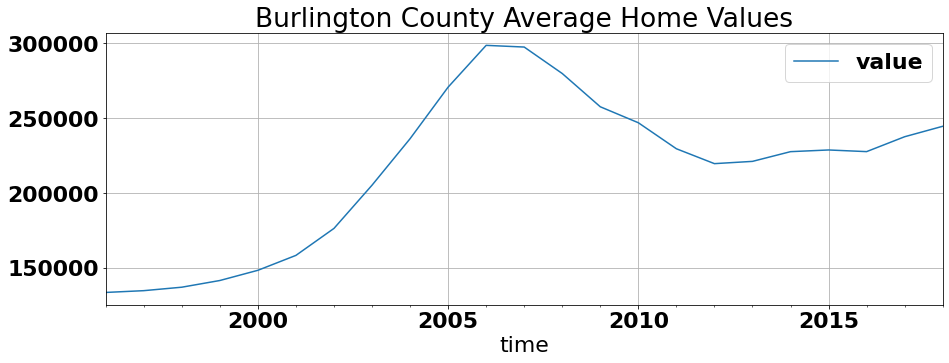

In [55]:
plot_values(burlington_df, 'Burlington County Average Home Values')

In [56]:
county_roi(burlington_df)

Average County Return on Investment (1996-2018): 0.83


### Union County Analysis

In [57]:
union_df = county_df('Union')
union_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60592,7083,Union,NJ,New York,Union,862,152400.0
1996-04-01,60551,7036,Linden,NJ,New York,Union,1582,131700.0
1996-04-01,60569,7060,Plainfield,NJ,New York,Union,2282,126300.0
1996-04-01,60632,7202,Elizabeth,NJ,New York,Union,2350,123000.0
1996-04-01,60574,7065,Rahway,NJ,New York,Union,3396,126400.0


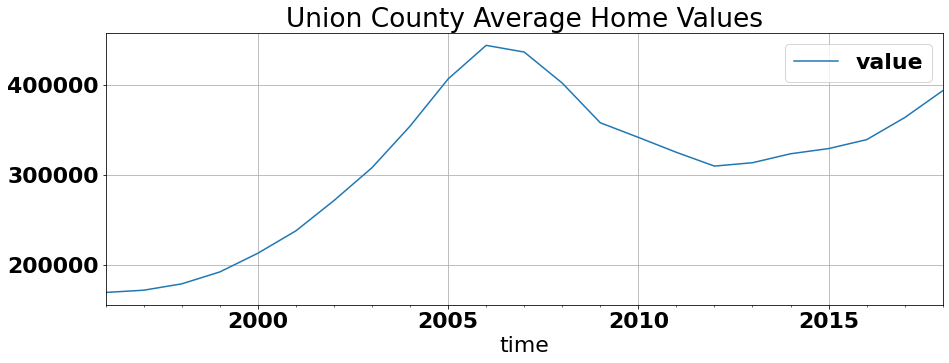

In [58]:
plot_values(union_df, 'Union County Average Home Values')

In [59]:
county_roi(union_df)

Average County Return on Investment (1996-2018): 1.33


### Mercer County Analysis

In [60]:
mercer_df = county_df('Mercer')
mercer_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61100,8540,Princeton,NJ,Trenton,Mercer,989,270200.0
1996-04-01,61129,8618,Trenton,NJ,Trenton,Mercer,2418,74700.0
1996-04-01,61141,8648,Lawrence,NJ,Trenton,Mercer,3098,161000.0
1996-04-01,61127,8610,Hamilton,NJ,Trenton,Mercer,3310,100500.0
1996-04-01,61090,8520,East Windsor,NJ,Trenton,Mercer,3909,139500.0


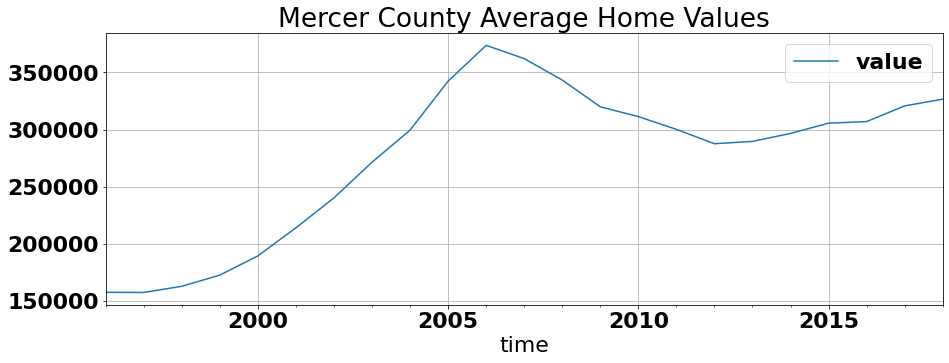

In [61]:
plot_values(mercer_df, 'Mercer County Average Home Values')

In [62]:
county_roi(mercer_df)

Average County Return on Investment (1996-2018): 1.07


### Morris County Analysis

In [63]:
morris_df = county_df('Morris')
morris_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60884,7960,Morris,NJ,New York,Morris,1281,285900.0
1996-04-01,60564,7054,Parsippany-Troy Hills,NJ,New York,Morris,3444,220700.0
1996-04-01,60848,7869,Randolph,NJ,New York,Morris,4926,253900.0
1996-04-01,60847,7866,Rockaway,NJ,New York,Morris,5332,165800.0
1996-04-01,60806,7801,Dover,NJ,New York,Morris,5527,134200.0


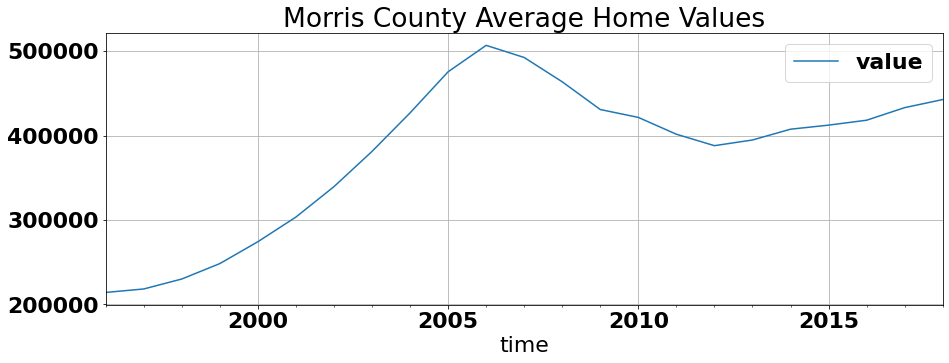

In [64]:
plot_values(morris_df, 'Morris County Average Home Values')

In [65]:
county_roi(morris_df)

Average County Return on Investment (1996-2018): 1.07


### Atlantic County Analysis

In [66]:
atlantic_df = county_df('Atlantic')
atlantic_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61021,8234,Egg Harbor,NJ,Atlantic City,Atlantic,1481,133900.0
1996-04-01,61056,8330,Hamilton,NJ,Atlantic City,Atlantic,3530,103800.0
1996-04-01,61003,8205,Galloway,NJ,Atlantic City,Atlantic,3758,116600.0
1996-04-01,60931,8037,Hammonton,NJ,Atlantic City,Atlantic,4930,97000.0
1996-04-01,61079,8406,Ventnor City,NJ,Atlantic City,Atlantic,6415,119300.0


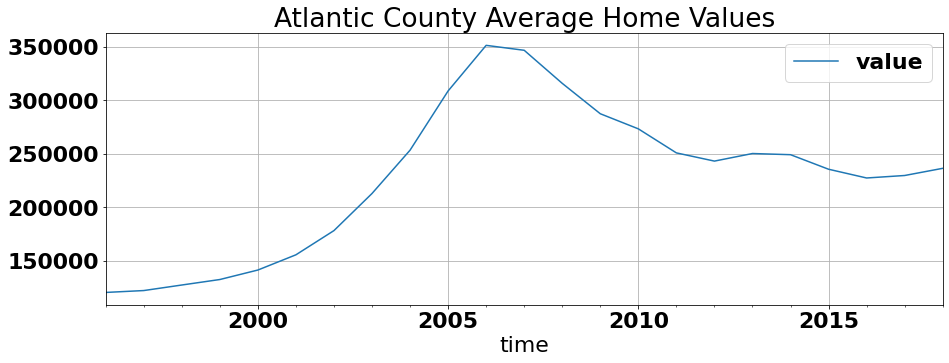

In [67]:
plot_values(atlantic_df, 'Atlantic County Average Home Values')

In [68]:
county_roi(atlantic_df)

Average County Return on Investment (1996-2018): 0.96


### Gloucester County Analysis

In [69]:
gloucester_df = county_df('Gloucester')
gloucester_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60983,8094,Monroe,NJ,Philadelphia,Gloucester,1745,105600.0
1996-04-01,60985,8096,Deptford,NJ,Philadelphia,Gloucester,2060,99600.0
1996-04-01,60970,8080,Washington,NJ,Philadelphia,Gloucester,2330,140000.0
1996-04-01,60922,8028,Glassboro,NJ,Philadelphia,Gloucester,5606,106100.0
1996-04-01,60974,8085,Woolwich,NJ,Philadelphia,Gloucester,6170,149300.0


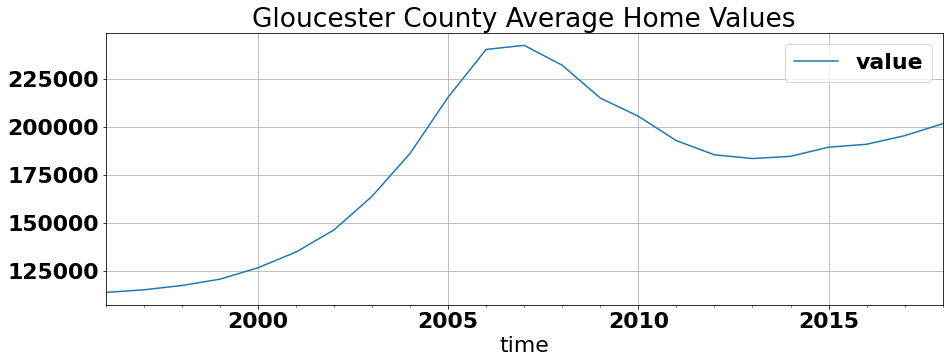

In [70]:
plot_values(gloucester_df, 'Gloucester County Average Home Values')

In [71]:
county_roi(gloucester_df)

Average County Return on Investment (1996-2018): 0.77


### Cumberland County Analysis

In [72]:
cumberland_df = county_df('Cumberland')
cumberland_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61071,8360,Vineland,NJ,Vineland,Cumberland,1779,80000.0
1996-04-01,61036,8302,Bridgeton,NJ,Vineland,Cumberland,2116,75500.0
1996-04-01,61057,8332,Millville,NJ,Vineland,Cumberland,2221,71900.0
1996-04-01,61072,8361,Vineland,NJ,Vineland,Cumberland,6380,113200.0
1996-05-01,61071,8360,Vineland,NJ,Vineland,Cumberland,1779,80000.0


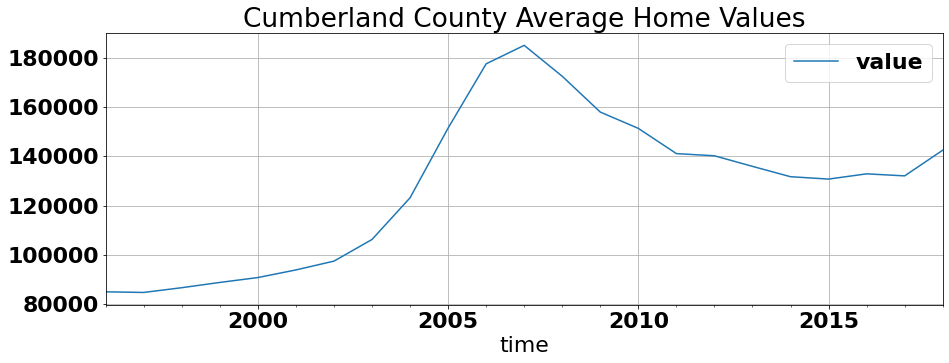

In [73]:
plot_values(cumberland_df, 'Cumberland County Average Home Values')

In [74]:
county_roi(cumberland_df)

Average County Return on Investment (1996-2018): 0.68


### Warren County Analysis

In [75]:
warren_df = county_df('Warren')
warren_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60828,7840,Hackettstown,NJ,Allentown,Warren,2987,154500.0
1996-04-01,61222,8865,Phillipsburg,NJ,Allentown,Warren,3080,98700.0
1996-04-01,60859,7882,Washington,NJ,Allentown,Warren,6995,133700.0
1996-04-01,60814,7825,Blairstown,NJ,Allentown,Warren,9049,171000.0
1996-04-01,60813,7823,Belvidere,NJ,Allentown,Warren,9157,126800.0


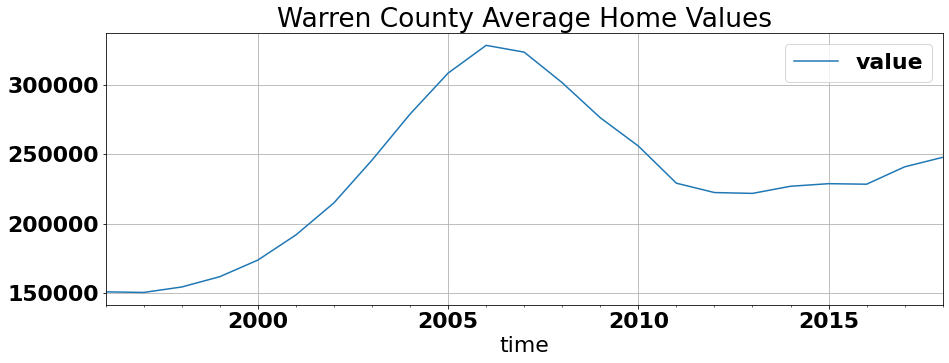

In [76]:
plot_values(warren_df, 'Warren County Average Home Values')

In [77]:
county_roi(warren_df)

Average County Return on Investment (1996-2018): 0.64


### Hunterdon County Analysis

In [78]:
hunterdon_df = county_df('Hunterdon')
hunterdon_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61191,8822,Raritan,NJ,New York,Hunterdon,3254,223400.0
1996-04-01,61241,8889,Readington,NJ,New York,Hunterdon,8617,236000.0
1996-04-01,61202,8833,Clinton,NJ,New York,Hunterdon,8917,276400.0
1996-04-01,61095,8530,Lambertville,NJ,New York,Hunterdon,9026,173700.0
1996-04-01,61210,8848,Holland,NJ,New York,Hunterdon,9267,177100.0


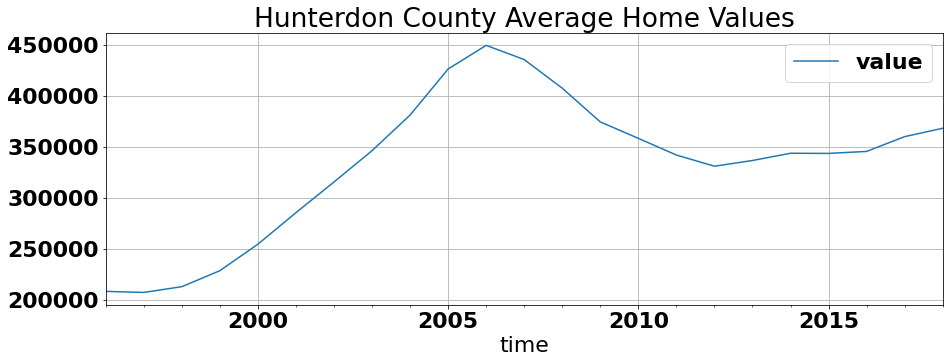

In [79]:
plot_values(hunterdon_df, 'Hunterdon County Average Home Values')

In [80]:
county_roi(hunterdon_df)

Average County Return on Investment (1996-2018): 0.77


### Cape May County Analysis

In [81]:
cape_may_df = county_df('Cape May')
cape_may_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61017,8226,Ocean City,NJ,Ocean City,Cape May,3631,182400.0
1996-04-01,61002,8204,Lower,NJ,Ocean City,Cape May,4537,107700.0
1996-04-01,61004,8210,Middle,NJ,Ocean City,Cape May,5878,93300.0
1996-04-01,61034,8260,North Wildwood,NJ,Ocean City,Cape May,6038,89500.0
1996-04-01,61032,8251,Villas,NJ,Ocean City,Cape May,7399,61800.0


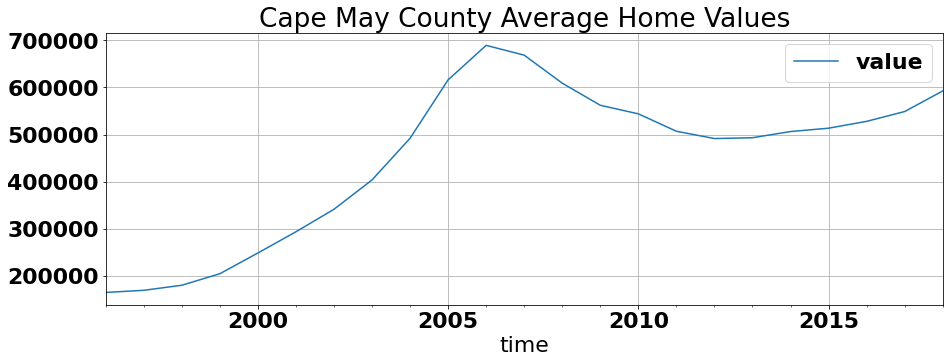

In [82]:
plot_values(cape_may_df, 'Cape May County Average Home Values')

In [83]:
county_roi(cape_may_df)

Average County Return on Investment (1996-2018): 2.61


### Sussex County Analysis

In [84]:
sussex_df = county_df('Sussex')
sussex_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60844,7860,Newton,NJ,New York,Sussex,4412,136300.0
1996-04-01,60850,7871,Sparta,NJ,New York,Sussex,5720,190000.0
1996-04-01,60684,7461,Wantage,NJ,New York,Sussex,6188,137500.0
1996-04-01,60830,7843,Hopatcong,NJ,New York,Sussex,7883,121200.0
1996-04-01,60660,7419,Hardyston,NJ,New York,Sussex,8472,134300.0


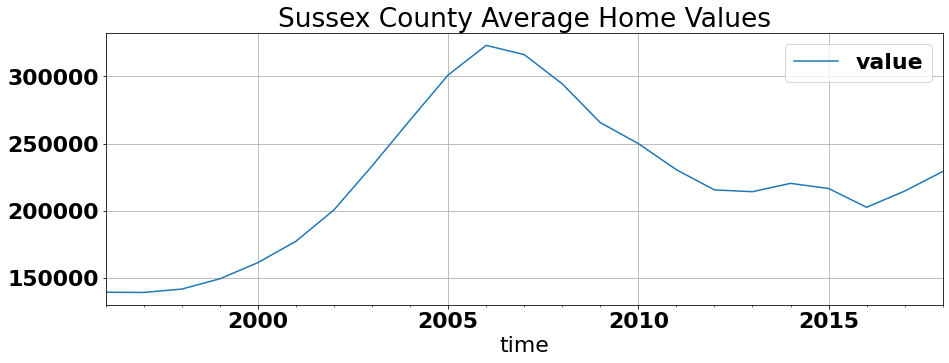

In [85]:
plot_values(sussex_df, 'Sussex County Average Home Values')

In [86]:
county_roi(sussex_df)

Average County Return on Investment (1996-2018): 0.64


### Salem County Analysis

In [87]:
salem_df = county_df('Salem')
salem_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60960,8070,Pennsville,NJ,Philadelphia,Salem,7321,90700.0
1996-04-01,60959,8069,Carneys Point,NJ,Philadelphia,Salem,7541,70500.0
1996-04-01,61045,8318,Pittsgrove,NJ,Philadelphia,Salem,7902,89000.0
1996-04-01,60969,8079,Salem,NJ,Philadelphia,Salem,8038,68000.0
1996-04-01,60987,8098,Pilesgrove,NJ,Philadelphia,Salem,8960,106000.0


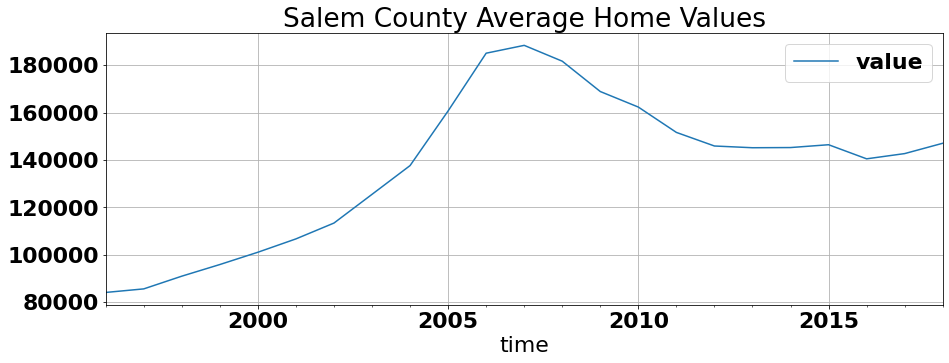

In [88]:
plot_values(salem_df, 'Salem County Average Home Values')

In [89]:
county_roi(salem_df)

Average County Return on Investment (1996-2018): 0.75


## County ROI Analysis

In [90]:
#Get unique county names in order to append to a list
unique_counties = []
for c in nj_df.CountyName.unique():
    unique_counties.append(c)

In [91]:
#Create a dictionary of counties along with their ROI
roi_dict = dict(zip(unique_counties, roi_lst))

In [92]:
#ROI Dictionary
roi_dict

{'Hudson': 3.15,
 'Ocean': 1.54,
 'Middlesex': 1.17,
 'Somerset': 0.97,
 'Monmouth': 1.76,
 'Passaic': 0.98,
 'Essex': 1.63,
 'Camden': 0.82,
 'Bergen': 1.32,
 'Burlington': 0.83,
 'Union': 1.33,
 'Mercer': 1.07,
 'Morris': 1.07,
 'Atlantic': 0.96,
 'Gloucester': 0.77,
 'Cumberland': 0.68,
 'Warren': 0.64,
 'Hunterdon': 0.77,
 'Cape May': 2.61,
 'Sussex': 0.64,
 'Salem': 0.75}

In [179]:
#Use ROI Dictionary to create a dataframe and sort by highest value for analysis
county_roi_df = pd.DataFrame(list(roi_dict.items()),columns = ['County','Average Return on Investment']) 
county_roi_df.sort_values(by='Average Return on Investment', ascending=False).reset_index(drop=True)

,County,Average Return on Investment
0,Hudson,3.15
1,Cape May,2.61
2,Monmouth,1.76
3,Essex,1.63
4,Ocean,1.54
5,Union,1.33
6,Bergen,1.32
7,Middlesex,1.17
8,Mercer,1.07
9,Morris,1.07


### Past ROI Summary

 - Overall the top three ROI NJ counties from 1996-2018 were Hudson County with a 315% ROI, followed by Cape May County at 261%, and finally Monmouth County at 176%. Warren and Sussex County were also tied for last in ROI at 64% each. Going forward with the analysis I would expect the top counties here to possibly level off going forward with a lesser demand at the current high prices for these counties. It will also be interesting to see if the lower counties here turn out to be the highest in terms of furture ROI predicitons based on the fact that there is more room to grow in home value for these counties.  

In [94]:
hudson_yearly = hudson_df['value'].resample(rule='A').mean()
cape_may_yearly = cape_may_df['value'].resample(rule='A').mean()
monmouth_yearly = monmouth_df['value'].resample(rule='A').mean()

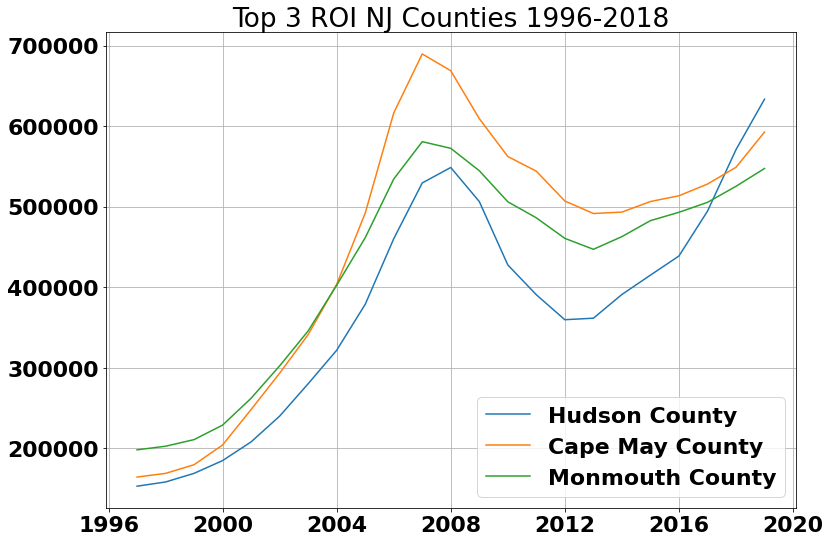

In [95]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(hudson_yearly, color='tab:blue', label='Hudson County')
ax.plot(cape_may_yearly, color='tab:orange', label='Cape May County')
ax.plot(monmouth_yearly, color='tab:green', label='Monmouth County')
ax.legend()
plt.grid()
plt.title('Top 3 ROI NJ Counties 1996-2018')
fig.tight_layout()

 - Overall the top three ROI counties appear to be following a general upward trend aside from the downturn due to the 2008 economic recession. Hudson county appears to have been hit the hardest by the recession but has since sharly bounced back. Also Cape May County had the overall highest average value close to 700,000 before the recession and did not get hit as hard as Hudson County. Monmouth County started at the highest average value in 1996 but has since been somewhere in the middle of the other two counties. Going forward it will be interesting to see if Cape May will get back to its highest point of 700,000 and whether Hudson County values will continue to sharly rise or will begin to level off.    

## SARIMA Modeling

 - SARIMA models were choosen for the data because the will take into account the seasonality component associated with real estate data. A stepwise fit for each county will be run in order to determine the optimal model order for each. After the optimal order is determined the data will then be fit to the SARIMA model. Predictions will then be made for the next 5 years. Forecasted 5 year ROI will then be analyzed by county in order to determine the top 3 highest ROI counties. 

In [96]:
forcasted_roi = []
def sarima_model(county_df, model_order):
#Takes in a county dataframe and model order, runs a SARIMA model on the county and returns forcasted ROI of the county
    #Break into training and testing data
    train = county_df.iloc[:253]
    test = county_df.iloc[253:]
    #Create model
    model = SARIMAX(train['value'], order = model_order)
    #Fit model
    results = model.fit()
    start = len(train)
    end = len(train) + len(test) - 1
    #Make predictions from model
    predictions = results.predict(start, end, typ='levels')
    #Calculate RMSE
    error = rmse(test['value'], predictions)
    #Create model for future predictions
    future_model = SARIMAX(county_df['value'], order = model_order)
    #Fit future model
    results_future = future_model.fit()
    #Get the forecast
    fcast = results_future.predict(len(county_df), len(county_df)+60, typ='levels')
    #Create dataframe of forecast results
    fcast_df = pd.DataFrame(fcast)
    #Get initial cost
    cost = fcast_df.iloc[0,0]
    #Get end value
    value = fcast_df.iloc[-1,0]
    #Calculate return on investment
    ROI = (value-cost)/cost
    #Append ROI to a list
    forcasted_roi.append(round(ROI,2))
    #Return initial cost, forecasted value, forecasted ROI, and RMSE
    return print(f'Initial Cost: {round(cost)}, Forcasted Value: {round(value)}, Forcasted ROI: {round(ROI,2)}, RMSE: {round(error)}')

In [97]:
def county_stepwise_fit(df):
    #Takes in a county dataframe, resmaples by month, and returns a stepwise fit summary for the dataframe
    monthly_df = df.resample(rule='M').mean()
    stepwise_fit = auto_arima(monthly_df['value'], trace=True)
    return stepwise_fit.summary()

### Hudson County Model

In [98]:
#Run stepwise fit to determine optimal model order
county_stepwise_fit(hudson_df)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5020.377, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5107.194, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5073.207, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5080.000, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5162.038, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5040.837, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4998.435, Time=0.99 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4995.994, Time=0.66 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5065.934, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5072.926, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5002.610, Time=0.29 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 4.421 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2493.997
Date:                Wed, 19 May 2021   AIC                           4995.994
Time:                        09:08:06   BIC                           5010.298
Sample:                             0   HQIC                          5001.741
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     68.6273     34.672      1.979      0.048       0.672     136.582
ar.L1          0.9343      0.016     57.300      0.000       0.902       0.966
ma.L1         -0.8756      0.020    -42.871      0.000      -0.916      -0.836
sigma2      8.785e+06      0.000   1.79e+10      0.000    8.78e+06    8.78e+06
===================================================================================
Ljung-Box (L1) (Q):                 211.20   Jarque-Bera (JB):                49.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.73
Prob(H) (two-sided):                  0.45   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.55e+25. Standard errors may be unstable.
"""

In [99]:
def monthly_df(df):
    #Takes in a dataframe and resamples by month according to the mean value
    monthly_df = df.resample(rule='M').mean()
    return monthly_df

In [100]:
#Create monthly dataframe for model
hudson_monthly = monthly_df(hudson_df)

In [101]:
#Run SARIMA Model with recommended order
sarima_model(hudson_monthly, (1,1,1))

Initial Cost: 649958, Forcasted Value: 714668, Forcasted ROI: 0.1, RMSE: 47456


### Ocean County Model

In [102]:
county_stepwise_fit(ocean_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=4130.035, Time=0.80 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4123.171, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4123.767, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4123.024, Time=0.27 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4123.962, Time=0.90 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=4121.623, Time=0.26 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=4121.488, Time=0.76 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=4122.908, Time=0.43 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=4120.913, Time=0.58 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=4122.908, Time=0.66 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=4124.909, Time=0.59 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=4122.915, Time=0.88 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 6.209 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 3)   Log Likelihood               -2056.456
Date:                Wed, 19 May 2021   AIC                           4120.913
Time:                        09:08:13   BIC                           4135.202
Sample:                             0   HQIC                          4126.655
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0179      0.013      1.402      0.161      -0.007       0.043
ma.L2         -0.0423      0.011     -3.968      0.000      -0.063      -0.021
ma.L3         -0.0307      0.012     -2.470      0.014      -0.055      -0.006
sigma2      3.478e+05   2.03e+04     17.111      0.000    3.08e+05    3.88e+05
===================================================================================
Ljung-Box (L1) (Q):                  21.04   Jarque-Bera (JB):                75.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.67   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [103]:
ocean_monthly = monthly_df(ocean_df)

In [104]:
sarima_model(ocean_monthly, (0,2,3))

Initial Cost: 359819, Forcasted Value: 392297, Forcasted ROI: 0.09, RMSE: 8026


### Middlesex County Model

In [105]:
county_stepwise_fit(middlesex_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=4056.986, Time=0.98 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4052.186, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4052.623, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4050.816, Time=0.13 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4055.447, Time=0.29 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=4052.365, Time=0.15 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=4052.759, Time=0.35 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 2.645 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -2023.408
Date:                Wed, 19 May 2021   AIC                           4050.816
Time:                        09:08:16   BIC                           4057.960
Sample:                             0   HQIC                          4053.687
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0336      0.010      3.241      0.001       0.013       0.054
sigma2      2.772e+05    1.5e+04     18.484      0.000    2.48e+05    3.07e+05
===================================================================================
Ljung-Box (L1) (Q):                  30.90   Jarque-Bera (JB):               106.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              28.84   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [106]:
middlesex_monthly = monthly_df(middlesex_df)

In [107]:
sarima_model(middlesex_monthly, (0,2,1))

Initial Cost: 337442, Forcasted Value: 413360, Forcasted ROI: 0.22, RMSE: 17452


### Somerset County Model

In [108]:
county_stepwise_fit(somerset_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.69 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4156.879, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4160.954, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4157.776, Time=0.24 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4160.219, Time=0.45 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4158.861, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 1.481 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2077.439
Date:                Wed, 19 May 2021   AIC                           4156.879
Time:                        09:08:18   BIC                           4160.451
Sample:                             0   HQIC                          4158.315
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.232e+05    2.3e+04     18.375      0.000    3.78e+05    4.68e+05
===================================================================================
Ljung-Box (L1) (Q):                  40.12   Jarque-Bera (JB):               119.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              34.35   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [109]:
somerset_monthly = monthly_df(somerset_df)

In [110]:
sarima_model(somerset_monthly, (0,2,0))

Initial Cost: 520348, Forcasted Value: 588348, Forcasted ROI: 0.13, RMSE: 9014


### Monmouth County Model

In [111]:
county_stepwise_fit(monmouth_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=4277.022, Time=0.65 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4272.548, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4272.155, Time=0.21 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4272.135, Time=0.29 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4275.918, Time=0.29 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=4274.052, Time=0.30 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=4275.792, Time=1.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=4274.137, Time=0.53 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 3.356 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -2134.067
Date:                Wed, 19 May 2021   AIC                           4272.135
Time:                        09:08:22   BIC                           4279.279
Sample:                             0   HQIC                          4275.006
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0200      0.008      2.360      0.018       0.003       0.037
sigma2      6.474e+05   3.39e+04     19.081      0.000    5.81e+05    7.14e+05
===================================================================================
Ljung-Box (L1) (Q):                  50.38   Jarque-Bera (JB):               142.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              24.99   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [112]:
monmouth_monthly = monthly_df(monmouth_df)

In [113]:
sarima_model(monmouth_monthly, (0,2,1))

Initial Cost: 548665, Forcasted Value: 534684, Forcasted ROI: -0.03, RMSE: 7831


### Passaic County Model

In [114]:
county_stepwise_fit(passaic_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.15 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4013.442, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4013.830, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4012.743, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4013.928, Time=0.38 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=4012.749, Time=0.24 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=4016.573, Time=1.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=4014.574, Time=0.56 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 3.514 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -2004.371
Date:                Wed, 19 May 2021   AIC                           4012.743
Time:                        09:08:26   BIC                           4019.887
Sample:                             0   HQIC                          4015.614
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0323      0.012      2.791      0.005       0.010       0.055
sigma2      2.403e+05   1.29e+04     18.592      0.000    2.15e+05    2.66e+05
===================================================================================
Ljung-Box (L1) (Q):                  24.55   Jarque-Bera (JB):               117.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              29.25   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [115]:
passaic_monthly = monthly_df(passaic_df)

In [116]:
sarima_model(passaic_monthly, (0,2,1))

Initial Cost: 302528, Forcasted Value: 468578, Forcasted ROI: 0.55, RMSE: 9767


### Essex County Model

In [117]:
county_stepwise_fit(essex_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=4302.683, Time=0.67 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4273.317, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4273.739, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4284.571, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4287.525, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4275.281, Time=0.03 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 1.161 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2135.659
Date:                Wed, 19 May 2021   AIC                           4273.317
Time:                        09:08:28   BIC                           4276.889
Sample:                             0   HQIC                          4274.753
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.569e+05   3.62e+04     18.153      0.000    5.86e+05    7.28e+05
===================================================================================
Ljung-Box (L1) (Q):                  32.95   Jarque-Bera (JB):                99.58
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              47.39   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [118]:
essex_monthly = monthly_df(essex_df)

In [119]:
sarima_model(essex_monthly, (0,2,0))

Initial Cost: 512204, Forcasted Value: 367964, Forcasted ROI: -0.28, RMSE: 19852


### Camden County Model

In [120]:
county_stepwise_fit(camden_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=3795.089, Time=0.39 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3815.990, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3810.781, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3809.051, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=3797.625, Time=0.38 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=3794.806, Time=0.21 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3808.063, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=3799.439, Time=0.16 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=3796.119, Time=0.54 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=3795.299, Time=0.22 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=3796.422, Time=0.56 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=3796.907, Time=0.42 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 3.150 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1893.403
Date:                Wed, 19 May 2021   AIC                           3794.806
Time:                        09:08:31   BIC                           3809.095
Sample:                             0   HQIC                          3800.549
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5753      0.132      4.372      0.000       0.317       0.833
ar.L2         -0.1838      0.018    -10.485      0.000      -0.218      -0.149
ma.L1         -0.4689      0.137     -3.419      0.001      -0.738      -0.200
sigma2      8.904e+04   4647.905     19.156      0.000    7.99e+04    9.81e+04
===================================================================================
Ljung-Box (L1) (Q):                  14.06   Jarque-Bera (JB):               119.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.22   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [121]:
camden_monthly = monthly_df(camden_df)

In [122]:
sarima_model(camden_monthly, (2,2,1))

Initial Cost: 194760, Forcasted Value: 255240, Forcasted ROI: 0.31, RMSE: 2259


### Bergen County Model

In [123]:
county_stepwise_fit(bergen_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.75 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4348.473, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4350.786, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4355.597, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4358.990, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4350.456, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 1.173 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2173.237
Date:                Wed, 19 May 2021   AIC                           4348.473
Time:                        09:08:33   BIC                           4352.045
Sample:                             0   HQIC                          4349.909
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.742e+05    3.8e+04     22.981      0.000       8e+05    9.49e+05
===================================================================================
Ljung-Box (L1) (Q):                  23.68   Jarque-Bera (JB):               383.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              40.97   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [124]:
bergen_monthly = monthly_df(bergen_df)

In [125]:
sarima_model(bergen_monthly, (0,2,0))

Initial Cost: 567009, Forcasted Value: 654055, Forcasted ROI: 0.15, RMSE: 26715


### Burlington County Model

In [126]:
county_stepwise_fit(burlington_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=3864.641, Time=0.57 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3867.391, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3866.136, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3865.329, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=3863.100, Time=0.46 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=3861.714, Time=0.13 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=3862.598, Time=0.22 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3864.983, Time=0.54 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=3864.516, Time=0.84 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=3863.668, Time=0.32 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 3.263 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 2)   Log Likelihood               -1927.857
Date:                Wed, 19 May 2021   AIC                           3861.714
Time:                        09:08:37   BIC                           3872.430
Sample:                             0   HQIC                          3866.021
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0503      0.014      3.692      0.000       0.024       0.077
ma.L2         -0.0575      0.012     -4.998      0.000      -0.080      -0.035
sigma2      1.281e+05   6871.029     18.644      0.000    1.15e+05    1.42e+05
===================================================================================
Ljung-Box (L1) (Q):                  17.70   Jarque-Bera (JB):               115.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              14.36   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [127]:
burlington_monthly = monthly_df(burlington_df)

In [128]:
sarima_model(burlington_monthly, (0,2,2))

Initial Cost: 247960, Forcasted Value: 319904, Forcasted ROI: 0.29, RMSE: 8035


### Union County Model

In [129]:
county_stepwise_fit(union_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=4201.410, Time=0.56 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4195.570, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4195.923, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4195.872, Time=0.19 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4198.971, Time=0.34 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4197.566, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 1.242 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2096.785
Date:                Wed, 19 May 2021   AIC                           4195.570
Time:                        09:08:38   BIC                           4199.142
Sample:                             0   HQIC                          4197.005
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.902e+05   2.76e+04     17.758      0.000    4.36e+05    5.44e+05
===================================================================================
Ljung-Box (L1) (Q):                  27.07   Jarque-Bera (JB):                82.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              30.75   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [130]:
union_monthly = monthly_df(union_df)

In [131]:
sarima_model(union_monthly, (0,2,0))

Initial Cost: 395415, Forcasted Value: 409492, Forcasted ROI: 0.04, RMSE: 9144


### Mercer County Model

In [132]:
county_stepwise_fit(mercer_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=3895.631, Time=0.57 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3888.134, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3886.514, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3886.338, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3887.751, Time=0.20 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=3887.253, Time=0.20 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=3888.108, Time=0.22 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.843 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1941.169
Date:                Wed, 19 May 2021   AIC                           3886.338
Time:                        09:08:41   BIC                           3893.482
Sample:                             0   HQIC                          3889.209
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0406      0.011      3.731      0.000       0.019       0.062
sigma2      1.474e+05   1.07e+04     13.833      0.000    1.27e+05    1.68e+05
===================================================================================
Ljung-Box (L1) (Q):                  29.30   Jarque-Bera (JB):                 9.40
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):              17.57   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [133]:
mercer_monthly = monthly_df(mercer_df)

In [134]:
sarima_model(mercer_monthly, (0,2,1))

Initial Cost: 331544, Forcasted Value: 449952, Forcasted ROI: 0.36, RMSE: 10396


### Morris County Model

In [135]:
county_stepwise_fit(morris_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.71 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4021.350, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4020.811, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4020.782, Time=0.13 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4024.639, Time=0.45 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=4022.635, Time=0.19 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=4022.734, Time=0.20 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 2.098 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -2008.391
Date:                Wed, 19 May 2021   AIC                           4020.782
Time:                        09:08:43   BIC                           4027.926
Sample:                             0   HQIC                          4023.653
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0217      0.009      2.540      0.011       0.005       0.039
sigma2      2.481e+05   1.25e+04     19.913      0.000    2.24e+05    2.72e+05
===================================================================================
Ljung-Box (L1) (Q):                  48.43   Jarque-Bera (JB):               171.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              12.62   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
morris_monthly = monthly_df(morris_df)

In [137]:
sarima_model(morris_monthly, (0,2,1))

Initial Cost: 445570, Forcasted Value: 511841, Forcasted ROI: 0.15, RMSE: 3106


### Atlantic County Model

In [138]:
county_stepwise_fit(atlantic_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=4117.470, Time=0.52 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4126.228, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4122.926, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4122.501, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=4119.470, Time=0.49 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=4118.377, Time=0.43 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=4122.109, Time=0.69 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4123.820, Time=0.19 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=4118.227, Time=0.62 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=4117.561, Time=0.33 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=inf, Time=0.83 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=4119.269, Time=0.96 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 5.847 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(2, 2, 2)   Log Likelihood               -2053.735
Date:                Wed, 19 May 2021   AIC                           4117.470
Time:                        09:08:49   BIC                           4135.331
Sample:                             0   HQIC                          4124.648
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6819      0.212      3.213      0.001       0.266       1.098
ar.L2         -0.4090      0.190     -2.152      0.031      -0.781      -0.037
ma.L1         -0.6390      0.216     -2.960      0.003      -1.062      -0.216
ma.L2          0.3305      0.199      1.664      0.096      -0.059       0.720
sigma2      3.342e+05   2.04e+04     16.365      0.000    2.94e+05    3.74e+05
===================================================================================
Ljung-Box (L1) (Q):                  36.89   Jarque-Bera (JB):                55.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              11.60   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [139]:
atlantic_monthly = monthly_df(atlantic_df)

In [140]:
sarima_model(atlantic_monthly, (2,2,2))

Initial Cost: 237836, Forcasted Value: 265636, Forcasted ROI: 0.12, RMSE: 6145


### Gloucester County Model

In [141]:
county_stepwise_fit(gloucester_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=3879.977, Time=0.46 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3896.930, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3891.991, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3890.637, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=3879.398, Time=0.24 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=3885.620, Time=0.18 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3890.182, Time=0.18 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=3879.492, Time=0.36 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=3878.112, Time=0.19 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=3879.623, Time=0.36 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=3880.047, Time=0.37 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 3.161 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 3)   Log Likelihood               -1935.056
Date:                Wed, 19 May 2021   AIC                           3878.112
Time:                        09:08:54   BIC                           3892.401
Sample:                             0   HQIC                          3883.855
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0850      0.011      7.912      0.000       0.064       0.106
ma.L2         -0.0936      0.010     -9.443      0.000      -0.113      -0.074
ma.L3         -0.0910      0.014     -6.696      0.000      -0.118      -0.064
sigma2      1.228e+05   4437.394     27.676      0.000    1.14e+05    1.32e+05
===================================================================================
Ljung-Box (L1) (Q):                  26.83   Jarque-Bera (JB):              1738.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.02   Skew:                             1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [142]:
gloucester_monthly = monthly_df(gloucester_df)

In [143]:
sarima_model(gloucester_monthly, (0,2,3))

Initial Cost: 200462, Forcasted Value: 169156, Forcasted ROI: -0.16, RMSE: 12564


### Cumberland County Model

In [144]:
county_stepwise_fit(cumberland_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=4027.109, Time=0.47 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4048.158, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4044.326, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4042.209, Time=0.24 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=4028.196, Time=0.32 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=4026.320, Time=0.26 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4040.307, Time=0.18 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=4027.195, Time=0.15 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=4026.710, Time=0.39 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=4025.457, Time=0.20 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=4026.835, Time=0.28 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.66 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=4027.430, Time=0.40 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 3.647 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(3, 2, 0)   Log Likelihood               -2008.728
Date:                Wed, 19 May 2021   AIC                           4025.457
Time:                        09:08:58   BIC                           4039.745
Sample:                             0   HQIC                          4031.199
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0873      0.013      6.914      0.000       0.063       0.112
ar.L2         -0.1396      0.009    -15.396      0.000      -0.157      -0.122
ar.L3         -0.0606      0.018     -3.340      0.001      -0.096      -0.025
sigma2      2.158e+05   8661.101     24.921      0.000    1.99e+05    2.33e+05
===================================================================================
Ljung-Box (L1) (Q):                  17.61   Jarque-Bera (JB):               566.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.25   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [145]:
cumberland_monthly = monthly_df(cumberland_df)

In [146]:
sarima_model(cumberland_monthly, (3,2,0))

Initial Cost: 141790, Forcasted Value: 118027, Forcasted ROI: -0.17, RMSE: 2499


### Warren County Model

In [147]:
county_stepwise_fit(warren_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=4305.848, Time=0.61 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4301.616, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4303.255, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4303.416, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4304.535, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4303.597, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.986 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2149.808
Date:                Wed, 19 May 2021   AIC                           4301.616
Time:                        09:09:00   BIC                           4305.189
Sample:                             0   HQIC                          4303.052
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.315e+05   2.32e+04     31.577      0.000    6.86e+05    7.77e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.01   Jarque-Bera (JB):              1854.98
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):              39.79   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [148]:
warren_monthly = monthly_df(warren_df)

In [149]:
sarima_model(warren_monthly, (0,2,0))

Initial Cost: 250720, Forcasted Value: 322120, Forcasted ROI: 0.28, RMSE: 7619


### Hunterdon County Model

In [150]:
county_stepwise_fit(hunterdon_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4063.765, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4063.766, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4063.727, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4065.551, Time=0.48 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=4065.265, Time=0.20 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=4065.698, Time=0.17 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 2.771 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -2029.863
Date:                Wed, 19 May 2021   AIC                           4063.727
Time:                        09:09:03   BIC                           4070.871
Sample:                             0   HQIC                          4066.598
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0190      0.009      2.097      0.036       0.001       0.037
sigma2      2.928e+05   1.58e+04     18.481      0.000    2.62e+05    3.24e+05
===================================================================================
Ljung-Box (L1) (Q):                  43.48   Jarque-Bera (JB):               115.25
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              46.83   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [151]:
hunterdon_monthly = monthly_df(hunterdon_df)

In [152]:
sarima_model(hunterdon_monthly, (0,2,1))

Initial Cost: 369370, Forcasted Value: 394551, Forcasted ROI: 0.07, RMSE: 8982


### Cape May County Model

In [153]:
county_stepwise_fit(cape_may_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=4302.192, Time=0.28 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4253.668, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4251.081, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4251.141, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=4252.966, Time=0.15 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4289.481, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=4253.037, Time=0.26 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 1.331 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -2123.541
Date:                Wed, 19 May 2021   AIC                           4251.081
Time:                        09:09:04   BIC                           4258.225
Sample:                             0   HQIC                          4253.952
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0338      0.007      4.573      0.000       0.019       0.048
sigma2      5.916e+05   3.01e+04     19.650      0.000    5.33e+05    6.51e+05
===================================================================================
Ljung-Box (L1) (Q):                  67.39   Jarque-Bera (JB):               166.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              22.75   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [154]:
cape_may_monthly = monthly_df(cape_may_df)

In [155]:
sarima_model(cape_may_monthly, (1,2,0))

Initial Cost: 596383, Forcasted Value: 674841, Forcasted ROI: 0.13, RMSE: 26499


### Sussex County Model

In [156]:
county_stepwise_fit(sussex_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3936.352, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3932.989, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3932.589, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3933.900, Time=0.17 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=3932.722, Time=0.13 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=3931.496, Time=0.50 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=3931.585, Time=0.54 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=3929.894, Time=0.33 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=3931.436, Time=0.52 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=inf, Time=0.55 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=3931.760, Time=0.38 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 4.021 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 3)   Log Likelihood               -1960.947
Date:                Wed, 19 May 2021   AIC                           3929.894
Time:                        09:09:09   BIC                           3944.183
Sample:                             0   HQIC                          3935.637
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0514      0.010      5.184      0.000       0.032       0.071
ma.L2         -0.0357      0.014     -2.519      0.012      -0.064      -0.008
ma.L3         -0.0477      0.012     -3.831      0.000      -0.072      -0.023
sigma2      1.631e+05   9833.634     16.590      0.000    1.44e+05    1.82e+05
===================================================================================
Ljung-Box (L1) (Q):                  37.35   Jarque-Bera (JB):                57.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.60   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [157]:
sussex_monthly = monthly_df(sussex_df)

In [158]:
sarima_model(sussex_monthly, (0,2,3))

Initial Cost: 235718, Forcasted Value: 385593, Forcasted ROI: 0.64, RMSE: 1738


### Salem County Model

In [159]:
county_stepwise_fit(salem_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=4213.849, Time=0.47 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4222.908, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4220.163, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4219.038, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=4211.887, Time=0.35 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=4216.584, Time=0.15 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4219.244, Time=0.20 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=4219.860, Time=0.56 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=4214.367, Time=0.20 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=4211.947, Time=0.49 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=4216.621, Time=0.62 sec

Best model:  ARIMA(1,2,2)(0,0,0)[0]          
Total fit time: 3.843 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(1, 2, 2)   Log Likelihood               -2101.943
Date:                Wed, 19 May 2021   AIC                           4211.887
Time:                        09:09:13   BIC                           4226.176
Sample:                             0   HQIC                          4217.629
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7108      0.143      4.959      0.000       0.430       0.992
ma.L1         -0.6708      0.151     -4.445      0.000      -0.967      -0.375
ma.L2         -0.1235      0.016     -7.532      0.000      -0.156      -0.091
sigma2      4.774e+05   2.57e+04     18.548      0.000    4.27e+05    5.28e+05
===================================================================================
Ljung-Box (L1) (Q):                  19.13   Jarque-Bera (JB):               141.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.13   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [160]:
salem_monthly = monthly_df(salem_df)

In [161]:
sarima_model(salem_monthly, (1,2,2))

Initial Cost: 157266, Forcasted Value: 347010, Forcasted ROI: 1.21, RMSE: 6334


## Forcasted ROI Analysis

 - Will analyze forecasted ROI predictions in order to make business recommendations.

In [162]:
#Create dictionary of top forecasted counties for analysis
fcast_roi_dict = dict(zip(unique_counties, forcasted_roi))

In [163]:
fcast_roi_dict

{'Hudson': 0.1,
 'Ocean': 0.09,
 'Middlesex': 0.22,
 'Somerset': 0.13,
 'Monmouth': -0.03,
 'Passaic': 0.55,
 'Essex': -0.28,
 'Camden': 0.31,
 'Bergen': 0.15,
 'Burlington': 0.29,
 'Union': 0.04,
 'Mercer': 0.36,
 'Morris': 0.15,
 'Atlantic': 0.12,
 'Gloucester': -0.16,
 'Cumberland': -0.17,
 'Warren': 0.28,
 'Hunterdon': 0.07,
 'Cape May': 0.13,
 'Sussex': 0.64,
 'Salem': 1.21}

In [164]:
#Create dataframe of top forecasted ROI counties for analysis
fcast_roi_df = pd.DataFrame(list(fcast_roi_dict.items()),columns = ['County','Average Forecasted ROI']) 
fcast_roi_df.sort_values(by='Average Forecasted ROI', ascending=False).reset_index(drop=True)

,County,Average Forecasted ROI
0,Salem,1.21
1,Sussex,0.64
2,Passaic,0.55
3,Mercer,0.36
4,Camden,0.31
5,Burlington,0.29
6,Warren,0.28
7,Middlesex,0.22
8,Bergen,0.15
9,Morris,0.15


 - The top three forecasted counties according to the models are Salem at 121%, Sussex at 64%, and Passaic at 55%. 
 
 - The bottom forecasted counties according to the model are Monmouth, Gloucester, Cumberland, and Essex all with negative predicted ROI returns. 

### ROI Past and Future Comparison

In [180]:
roi_comparison = county_roi_df.merge(fcast_roi_df, how='inner')
roi_comparison['ROI Change %'] = roi_comparison['Average Forecasted ROI'] - roi_comparison['Average Return on Investment']
roi_comparison.sort_values(by='Average Forecasted ROI', ascending=False).reset_index(drop=True)

,County,Average Return on Investment,Average Forecasted ROI,ROI Change %
0,Salem,0.75,1.21,0.46
1,Sussex,0.64,0.64,0.00
2,Passaic,0.98,0.55,-0.43
3,Mercer,1.07,0.36,-0.71
4,Camden,0.82,0.31,-0.51
5,Burlington,0.83,0.29,-0.54
6,Warren,0.64,0.28,-0.36
7,Middlesex,1.17,0.22,-0.95
8,Bergen,1.32,0.15,-1.17
9,Morris,1.07,0.15,-0.92


 - Looking at the top three counties here, overall Salem county saw a 46% increase in its forecasted ROI compared to past ROI data, indicating that values here are growing at a faster rate than in the past. Sussex county has the same forecasted ROI compared to past ROI, indicating that values are growing at a consistent rate. While Passaic County saw a 43% decrease in ROI compared to its past ROI, this could indicate that while it still shows a high forecasted ROI of 55%, it is not growing as rapidly as in the past.    
 
 - Interestingly Hudson, Cape May, and Monmouth County, the top three ROI counties in the past all have low future forecasted ROI's at 13% and under. This could indicate that these counties may have leveled off in terms of home values and are not strong investments going forward. 

## Top 3 Forecasted ROI NJ Counties

In [166]:
def fcast_plot(df, model_order, title):
#Takes in a county dataframe, model order, and graph title, returns a graph of the 5-year forecast and RMSE
    train = df.iloc[:253]
    test = df.iloc[253:]
    model = SARIMAX(train['value'], order = model_order)
    results = model.fit()
    start = len(train)
    end = len(train) + len(test) - 1
    predictions = results.predict(start, end, typ='levels')
    error = rmse(test['value'], predictions)
    future_model = SARIMAX(df['value'], order = model_order)
    results_future = future_model.fit()
    fcast = results_future.predict(len(df), len(df)+60, typ='levels').rename('SARIMA Forecast')
    return df['value'].plot(legend=True, figsize=(12,8)), fcast.plot(legend=True), plt.grid(), plt.title(title), print(f'RMSE:{round(error)}')

RMSE:6334


(<AxesSubplot:title={'center':'Salem County 5-yr Forecast'}, xlabel='time'>,
 <AxesSubplot:title={'center':'Salem County 5-yr Forecast'}, xlabel='time'>,
 None,
 Text(0.5, 1.0, 'Salem County 5-yr Forecast'),
 None)

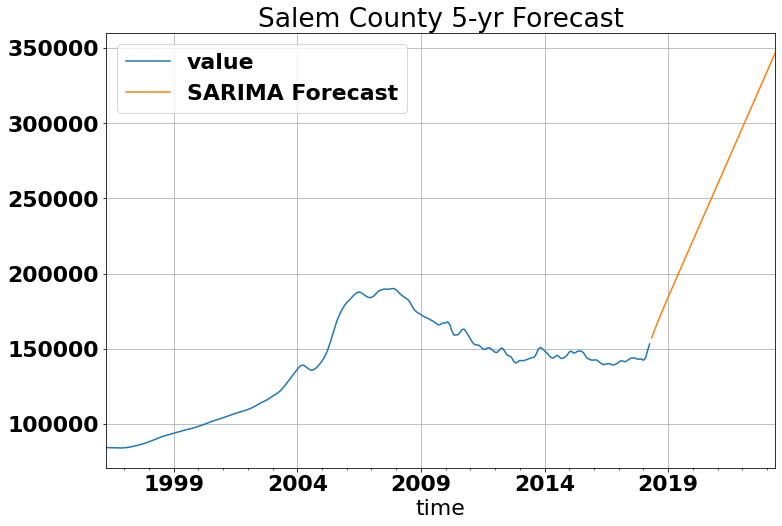

In [167]:
#Plot Salem County 5-year forecast and check RMSE
fcast_plot(salem_monthly, (1,2,2), 'Salem County 5-yr Forecast')

 - The top ROI forecasted NJ county is Salem County with a predicted increase of 121% over the next 5 years. The average initial cost for the county in 2018 is just over 150,000 dollars. While the predicted average value in 2023 is just under 350,000 dollars. The model used predicts average home values within 6,334 dollars of the actual average value.   

RMSE:1738


(<AxesSubplot:title={'center':'Sussex County 5-yr Forecast'}, xlabel='time'>,
 <AxesSubplot:title={'center':'Sussex County 5-yr Forecast'}, xlabel='time'>,
 None,
 Text(0.5, 1.0, 'Sussex County 5-yr Forecast'),
 None)

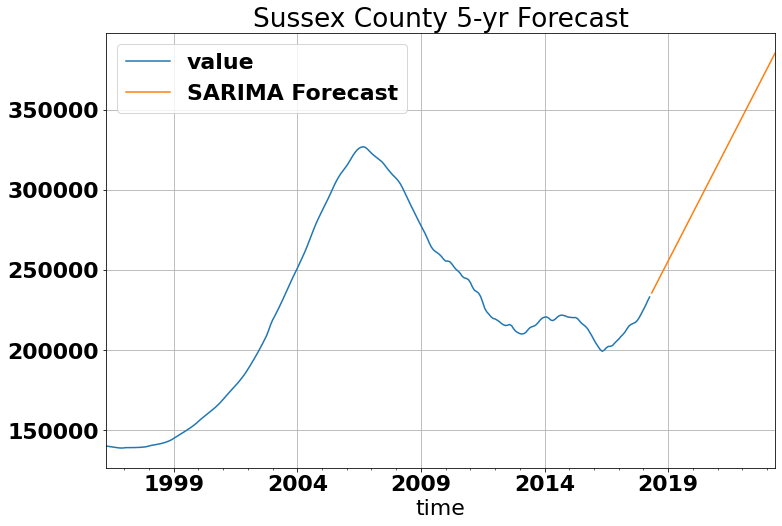

In [168]:
#Plot Sussex County 5-year forecast and check RMSE
fcast_plot(sussex_monthly, (0,2,3), 'Sussex County 5-yr Forecast')

 - The 2nd highest ROI forecasted NJ county is Sussex County with a predicted increase of 64% over the next 5 years. The average initial cost for the county in 2018 is just under 250,000 dollars. While the predicted average value in 2023 is just under 400,000 dollars. The model used predicts average home values within 1,738 dollars of the actual average value.   

RMSE:9767


(<AxesSubplot:title={'center':'Passaic County 5-yr Forecast'}, xlabel='time'>,
 <AxesSubplot:title={'center':'Passaic County 5-yr Forecast'}, xlabel='time'>,
 None,
 Text(0.5, 1.0, 'Passaic County 5-yr Forecast'),
 None)

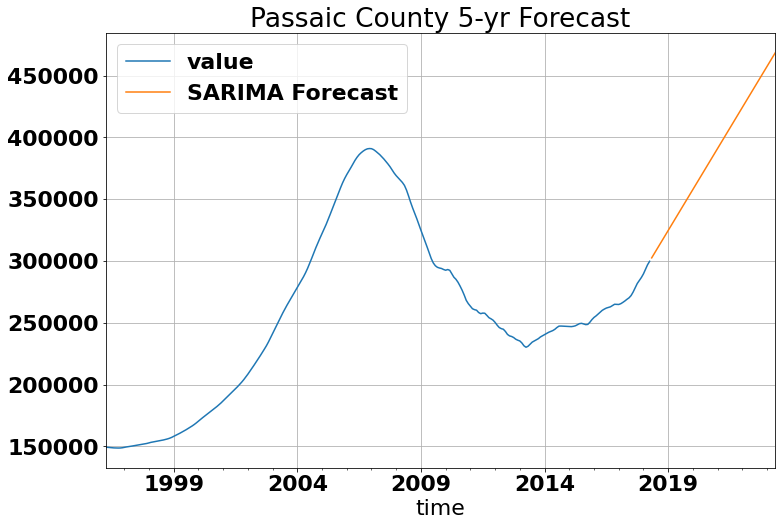

In [169]:
#Plot Passaic County 5-year forecast and check RMSE 
fcast_plot(passaic_monthly, (0,2,1), 'Passaic County 5-yr Forecast')

 - The 3rd ROI forecasted NJ county is Passaic County with a predicted increase of 55% over the next 5 years. The average initial cost for the county in 2018 is about 300,000 dollars. While the predicted average value in 2023 is about 475,000 dollars. The model used predicts average home values within 9,767 dollars of the actual average value.   

## Business Reccomendations/Conclusion

 - Overall business recommendations are as follows:
 
 1. Invest in Salem, Sussex, and Passaic County for the highest forecasted ROI returns. 
 2. Strongly reccommend to invest in Salem County due to its lowest initial cost of just over 150,000 dollars along with the overall highest forecasted ROI of 121%, almost double the next highest forecast.
 3. Recommend avoiding past top ROI counties including Hudson, Cape May, and Monmouth County. Despite the large past ROI data from these counties they may have leveled off in terms of value and likely will not be good investment options going forward.

## Future Work

 - Going forward future work on this project could include:
 
     1. Add another model type such as a RNN in order to compare its forecasts with the SARIMA models used here and check for similarities/differences between the models.
     
     2. Go deeper into the analysis by modeling the top counties by their cities in order to determine the top ROI cities within the counties thereby providing even more targeted recommendations with regard to where to invest.
     
     3. Take into account another evaluation metric along with ROI such as risk in order to provide more detailed investment recommendations.